### The goal of this notebook is simple exploratory analysis to identify conditions for word removal.
Given OCR is not completely reliable, this notebook will work to remove common occurrences that may altar the output of a topic model. It does this by ingesting all the parsed OCR, removing special characters, removing stop words, stemming, and then doing simple counts to identify popular edge cases to remove. This is so I can apply the same cleaning logic to all the documents instead of analyzing the output of each document individually.

In [14]:
from collections import Counter
import json 
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pathlib import Path
import regex as re
from wordcloud import WordCloud

import sys
sys.path.append(str(Path.cwd().parent.parent))
from utils import create_fh_logger

In [4]:
# locations of json files + a place to store a log
src = Path.cwd().parent.parent.parent.parent / 'processing' / 'nro_declassified' / 'ocr'
files = list(src.glob('*json'))
logs = src.parent.parent  / 'logs'
logs.mkdir(exist_ok=True)
logger = create_fh_logger(logs / "analyze_ocr.log")

In [5]:
def clean_text(txt):
    txt = re.sub("[^A-Za-z0-9 ]+", '', txt)
    txt = txt.lower()
    return txt
stopword = stopwords.words('english') # retrieve the stopwords
stopword.extend(['secret', 'fop', 'top', 'classified', 'declassified', 'approved', 'release', 'dod', 'general', 'page', 'via', 'would', 'throughout', 'director', 'chief'])

In [46]:
words = []
og_words = []
for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
    logger.info(f'Analyzing {str(file).encode("utf-8")}')
    data = data[file.stem] # foorgot why but it's a nested json with pdf name as first key
    for pg_num in data.keys():
        dat = data[pg_num]['text']
        dat = [word for word in dat if word != '']
        og_words.extend(dat)
        dat = [clean_text(word) for word in dat]
        dat = [word for word in dat if word not in stopword and word != '' and word != ' ']
        words.extend(dat)
    logger.info(f'Finished analyzing {str(file).encode("utf-8")}')

In [41]:
stemmer = SnowballStemmer(language='english')
stemmed = [stemmer.stem(word) for word in words] # stimmy
stemmed = [word for word in stemmed if not all(char == word[0] for char in word)] # remove words where the word is the same character
stemmed = [word for word in stemmed if len(word) > 2 and word.isalpha()] # has to be a word greater than 2 characters with all letters

In [42]:
word_freqs = Counter(stemmed) # create a dict of word: count

In [43]:
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freqs) # creates a wordcloud from the previously created counts

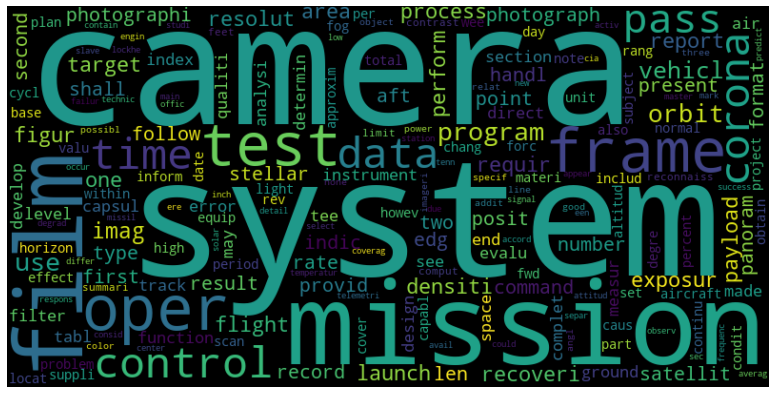

<Figure size 432x288 with 0 Axes>

In [44]:
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()
plt.savefig(Path.cwd().parent.parent / 'static' / 'cleaned_wordcloud.png')

In [22]:
print(f'There are {len(word_freqs.keys())} distinct words')

There are 282946 distinct words


Let us preview without the significant modifications and stop word removal.

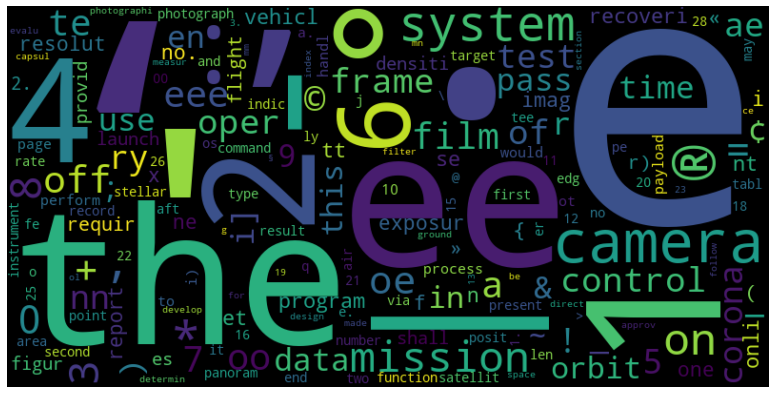

<Figure size 432x288 with 0 Axes>

In [48]:
stopword = stopwords.words('english') # retrieve the stopwords
stemmer = SnowballStemmer(language='english')
stemmed = [stemmer.stem(word) for word in og_words if word not in stopword] # stimmy
word_freqs = Counter(stemmed) # create a dict of word: count
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freqs) # creates a wordcloud from the previously created counts
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()
plt.savefig(Path.cwd().parent.parent / 'static' / 'original_wordcloud.png')